# SIMULATOR AND SUMMARY STATISTICS

In [19]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [98]:
# Load the minimum required library to run the functions
from Utils_functions import *
from numpy.random import uniform
from numpy import array, int64, where, concatenate, linspace, median, sum, log, zeros, mean, var, min, max, einsum
from scipy.integrate import cumulative_trapezoid
from scipy.signal import welch
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm


In [21]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 1 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = int(2e3)
t_corr = TotalT/50

In [22]:
time_steps_amount = int64(TotalT/dt) # Number of steps
sampled_point_amount = int64(TotalT/DeltaT) # Number of sampled points
sampling_delta_time_steps = int64(DeltaT/dt) # Number of steps between samples
t = linspace(0., TotalT,sampled_point_amount) # Time array

Chose the time characteristics of the input signal (total time, sample rate, numbero of simulations) and transform them into points info

In [23]:
# Limits for the parameters
prior_limits = [[1.5e4, 4e4], 
                [1e4, 140e4], 
                [3e-3, 16e-3], 
                [1.5e-2, 30e-2], 
                [1e-3, 6e-3], 
                [2e-2, 20e-2], 
                [0.5, 6], 
                [5.5, 15.5], 
                [1, 530]]

In [24]:
# Get the theta values from the prior in the different shapes
theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, n_sim)

In [100]:
## OLD SIMULATOR JUST TO WORK
@jit(nopython = True)
def Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta, i_state = None): # Cambiare type of theta to a Dictionary
    '''
    Simulates the system for a given set of parameters.

    INPUT
    dt: integration time
    DeltaT: sampling time
    TotalT: total simulation time
    n_sim: number of simulated trajectories
    theta: parameters
    i_state: initial state

    OUTPUT
    x_trace: x trace signal
    f_trace: f trace signal
    (x, y, f): state variables
    '''
    time_steps_amount = int64(TotalT/dt) # Number of steps
    sampled_point_amount = int64(TotalT/DeltaT) # Number of sampled points
    sampling_delta_time_steps = int64(DeltaT/dt) # Number of steps between samples
    
    # Aggiugnere controllo sul TotalT effettivo a fine simulazione
    # Aggiungere controllo sul sampling_delta_time_steps per sanity check
    # Controllare che sampled_point_amount*sampling_delta_time_steps = time_steps_amount
    
        
    # Unpack Parameters
    mu_x = theta[0]
    mu_y = theta[1]
    k_x = theta[2]
    k_y = theta[3]
    k_int = theta[4]
    tau = theta[5]
    eps = theta[6]
    D_x = theta[7]
    D_y = theta[8]
    
    # Handle initial state
    if i_state is None:
        x = zeros((n_sim,1), dtype = float32)
        y = zeros((n_sim,1), dtype = float32)
        f = zeros((n_sim,1), dtype = float32)
    else:
        if x.shape == (n_sim,1) or y.shape == (n_sim,1) or f.shape == (n_sim,1):
            raise Exception("Initial state has wrong shape, each should be (n_sim,1)")
        x, y, f = i_state
    
    # Initialize x_trace array
    
    x_trace = zeros((n_sim, sampled_point_amount), dtype = float32)
    f_trace = zeros((n_sim, sampled_point_amount), dtype = float32)
    y_trace = zeros((n_sim, sampled_point_amount), dtype = float32)

    sampling_counter = int64(1)
    
    # POSSIBLE OPTIM: You could overwrite the last used row of the trace to save memory and not create a proxy array
    
    # TRADEOFF: Memory vs Speed. We can generate the numbers here, or before. Maybe the time is the same... Should test
    
    # CHECK: Benchmark the version with the explicit dx, dy, df and the one with the x, y, f arrays with the calculation in the assigment
    
    for t in arange(time_steps_amount - 1):
        x[:,] = x[:,] + mu_x*(- k_x * x[:,] + k_int*y[:,])*dt                +          sqrt(2*mu_x*D_x*dt)     *randn(n_sim,1)
        y[:,] = y[:,] + mu_y*(-k_y*y[:,] + k_int*x[:,] + f[:,])*dt        +          sqrt(2*mu_y*D_y*dt)     *randn(n_sim,1)
        f[:,] = f[:,] + -(f[:,]/tau)*dt                                   +          sqrt(2*eps**2*dt/tau)   *randn(n_sim,1)

        sampling_counter = sampling_counter + 1
        if sampling_counter == sampling_delta_time_steps:
            x_trace[:, int(t/sampling_delta_time_steps)] = x[:,0]
            f_trace[:, int(t/sampling_delta_time_steps)] = f[:,0]
            y_trace[:, int(t/sampling_delta_time_steps)] = y[:,0]

            sampling_counter = int64(1)

    return x_trace, f_trace, y_trace # Check if this is right


In [26]:
# Dummy call to force compilation
theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1,0.1,1,1, theta)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [27]:
%%time
theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, n_sim)
x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

CPU times: user 3min 9s, sys: 606 ms, total: 3min 10s
Wall time: 3min 9s


In [28]:
# import _pickle as pickle
# with open('data/x_trace.pkl', 'wb') as f:
#     pickle.dump(x_trace, f)
    
# with open('data/f_trace.pkl', 'wb') as f:
#     pickle.dump(f_trace, f)

# with open('data/y_trace.pkl', 'wb') as f:
#     pickle.dump(y_trace, f)
    
# with open("data/theta.pkl", 'wb') as f:
#     pickle.dump(theta, f)

In [29]:
S_mean, Fx, Fy, S_tot = compute_entropy_production(x_trace, y_trace, f_trace, theta, n_sim)

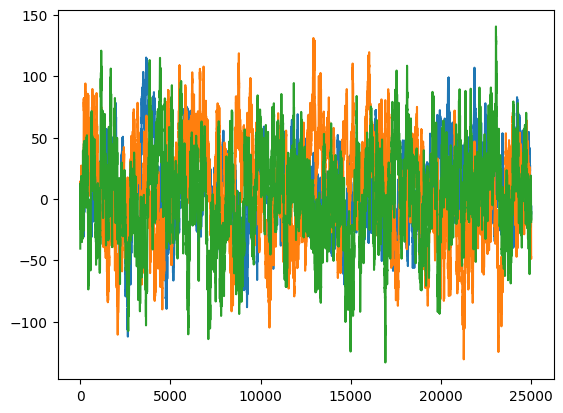

In [30]:
for i in range(3):
    plt.plot(x_trace[i,:])

Simulating the x trajectory and the f trajectory to then obtain the summary statistics, in this case the autocorrellation and the cross correllation in combination with the reduced energy production.

I don't know which formula we can pick to compute the reduce energy production, from autocorrellation, from cross correllation, all together?

ADD: Write a function GET_SUMMARY_STATISTICS() which is a list of functions, each function for a summoner statistic

In [31]:
%%time
list_stat = ["Cxx", "s_redx", "s_redf", "psdx"]
s = get_summary_statistics(list_stat, x_trace, f_trace, theta, DeltaT, 3, t, t_corr)
s.shape

CPU times: user 1min 4s, sys: 10.3 s, total: 1min 15s
Wall time: 1min 14s


torch.Size([2000, 5664])

Maybe we can select different summary statistics and usa some feature selection technique. If we use a lot of summary statistics maybe dimentionality reductions? PCA?
The idea is to use different summary statistics but to then to select the most important features of them deleting the correllations between them.

An example could be the Power spectral density for both x and f.
It can identify if there are any dominant frequencies in your data, or if the power is distributed across a range of frequencies, usefull for oscillatory behaviour

We can use directly the psds as input of the neural network or we can take some statistics about each one, like mean, median, max, min,variance, entropy, frequency of top power. We can think of more statistics

# INFERENCE STATISTICS

In [32]:
from torch import Tensor, Size
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from numpy import squeeze

In [33]:
# Prior distribution for sbi
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [34]:
# Call infer form sbi
infer = SNPE(prior=prior)
inferece = infer.append_simulations(theta_torch, s)

In [35]:
# Train the model
density_estimator = infer.train()
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 25 epochs.

In [104]:
# Simulate the observation(s)
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, n_sim=1)
x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)

In [ ]:
# Sample from the posterior
s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)
samples = posterior.sample((int(1e5),), x=s)

In [59]:
# Getting the some statistics from each marginal distribution

def get_centroids_from_samples(samples):
    mean_params = np.array([])
    mode_params = np.array([])

    for i in range(9):
        # Retrive the samples for the parameter i
        params = samples[:,i].numpy()
        # Compute the mean
        mean_params = np.concatenate((mean_params, [np.mean(params)]))
        # Compute the mode
        hist, bin_edges = np.histogram(params, bins=int(np.sqrt(params.shape[0])))
        max_index = np.argmax(hist)
        mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
        mode_params = np.concatenate((mode_params, [mode]))

    mean_params = mean_params.reshape(9, 1, 1)
    mode_params = mode_params.reshape(9, 1, 1)
    return mean_params, mode_params

mean_params, mode_params = get_centroids_from_samples(samples)

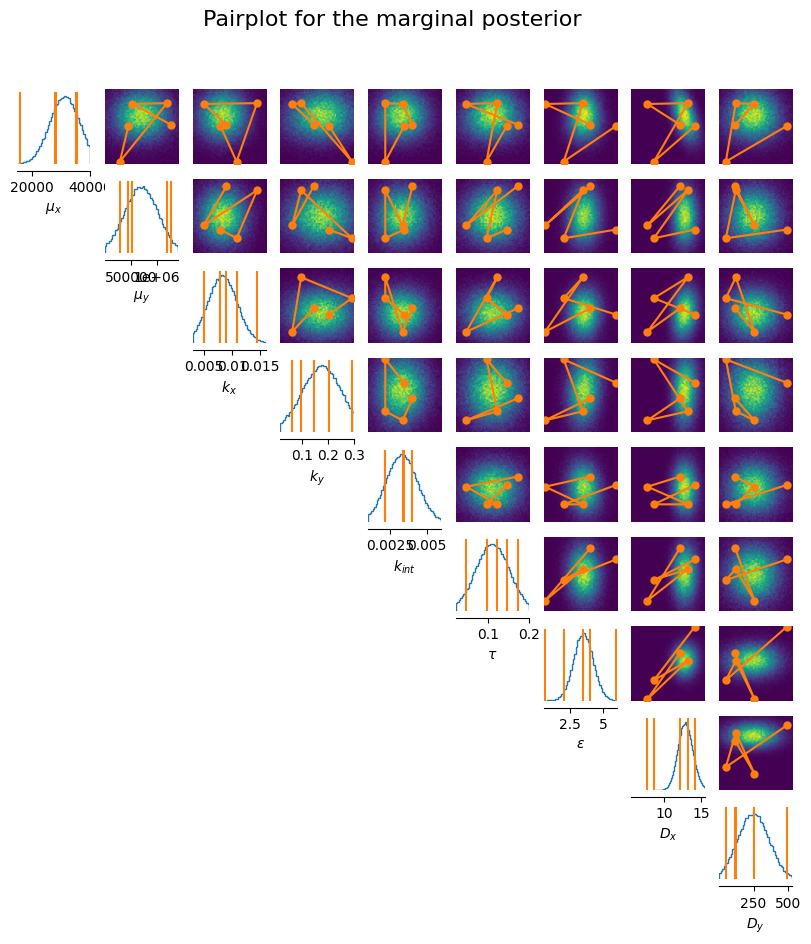

In [103]:
# Pairplot
label_theta = [r"$\mu_x$", r"$\mu_y$", r"$k_x$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$", r"$D_x$", r"$D_y$"]
import matplotlib as mpl
_ = analysis.pairplot(samples, points=[theta_torch_true], 
                      limits=prior_limits, figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)

In [40]:
# Compute a new trace using the mode parameters
x_trace_est, f_trace_est, y_trace_est = Simulator_noGPU(dt, DeltaT, TotalT, 1, mode_params)

# ENTROPY PRODUCTION

These are the formulas used to compute the entropy production
$$
S = \sum_{t=0}^{N_{\text{timesteps}}-2} \left( \text{data}_{t+1} - \text{data}_{t} \right) \cdot F\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right) \cdot D^{-1}\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right)
$$
$$
\sigma = \frac{{\mu_y \cdot \varepsilon^2}}{{1 + k_y \cdot \mu_y \cdot \tau - \frac{{k_{int}^2 \cdot \mu_x \cdot \mu_y \cdot \tau^2}}{{1 + k_x \cdot \mu_x \cdot \tau}}}}
$$

In [61]:
sigma_true, _, _, _ = compute_entropy_production(x_trace_true, y_trace_true, f_trace_true, theta_true, 1)
sigma_est, _, _, _ = compute_entropy_production(x_trace_est, y_trace_est, f_trace_est, mean_params, 1)

In [62]:
print(sigma_true, sigma_est)
sigma_true/sigma_est

224.1329115514977 192.81429101582583


1.1624289380764898

In [63]:
# Test on analytical entropy production on single realization
sigma_true_2, _, = compute_entropy_2(theta_true, 1)
sigma_est_2_mean, _, = compute_entropy_2(mean_params, 1)
sigma_est_2_mode, _, = compute_entropy_2(mode_params, 1)
print("Estimates for the analytical entropy production:")
print(f"True: %.2f, Mean: %.2f, Mode: %.2f" % (sigma_true_2[0][0], sigma_est_2_mean[0][0], sigma_est_2_mode[0][0]))

Estimates for the analytical entropy production:
True: 48.73, Mean: 289.99, Mode: 281.79


In [ ]:
# Test on analytical entropy production on multiple realizations
n_test = 2  # Number of test realizations
n_sim_obs = 5  # Number of observed trace per realization

sigma_true_array = np.zeros((n_test, 1))
sigma_est_array = np.zeros((n_test, n_sim_obs))

for i in tqdm(range(n_test)):
    # Get the true parameters and the n_sim_obs traces
    theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, n_sim=n_sim_obs)
    x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, n_sim_obs, theta_true)
    theta_numpy = array(theta_true)
        
    # Compute the (true) entropy production analytically
    sigma_true, _, = compute_entropy_2(theta_true, 1)
    sigma_true_array[i] = sigma_true[0][0]

    # Get the summary statistics
    s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)

    for j in range(n_sim_obs):
        # Sample from the posterior
        samples = posterior.sample((int(1e5),), x=s[j, :], show_progress_bars=False)

        # Get the mean and mode parameters
        mean_params, mode_params = get_centroids_from_samples(samples)

        # Compute the entropy production analytically
        sigma_est_mode, _, = compute_entropy_2(mode_params, 1)
        sigma_est_array[i, j] = sigma_est_mode[0][0]    

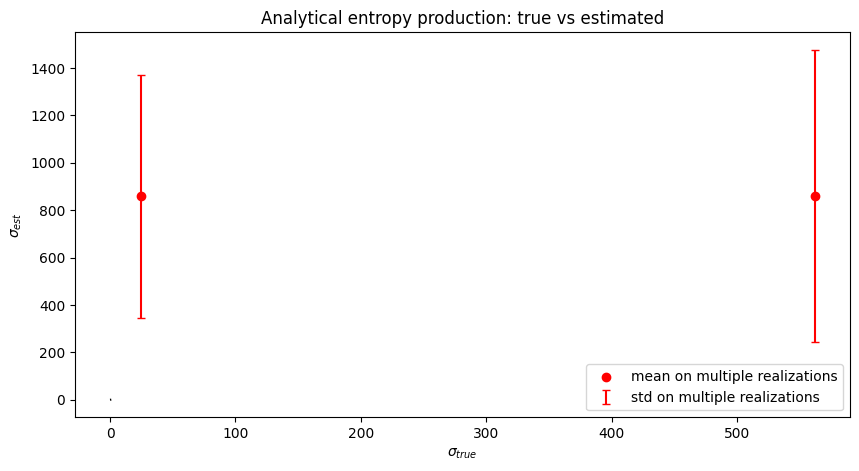

In [92]:
plt.figure(figsize=(10, 5))
plt.xlabel(r"$\sigma_{true}$")
plt.ylabel(r"$\sigma_{est}$")
plt.title("Analytical entropy production: true vs estimated")

plt.scatter(sigma_true_array, np.mean(sigma_est_array, axis=1), label='mean on multiple realizations', color='red')
plt.errorbar(sigma_true_array, np.mean(sigma_est_array, axis=1), yerr=np.std(sigma_est_array, axis=1, ddof=1), 
             fmt=' ', capsize=3, label='std on multiple realizations', color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend()

In [45]:
# Get the statistics of sigma directly out of the samples
sigma_samples = array([])
#sanity_check = array([])

for i in range(samples.shape[0]):
    sample = samples[i,:].numpy().reshape(9,1,1)
    #sanity_check = concatenate((sanity_check, [sample[0][0][0]]))
    sigma = compute_entropy_2(list(sample), 1)[0][0][0]
    sigma_samples = concatenate((sigma_samples, [sigma]))

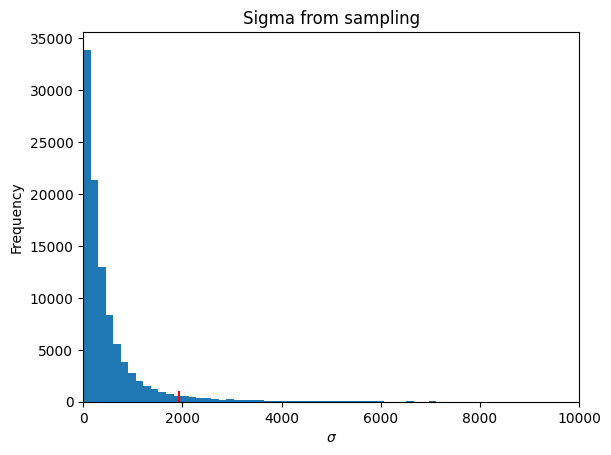

In [46]:
plt.xlim(0, 1e4)
plt.vlines(sigma_true_2, 0, 1e3, color='r')
plt.xlabel(r"$\sigma$")
plt.ylabel("Frequency")
plt.title("Sigma from sampling")
plt.hist(sigma_samples, bins=int(np.sqrt(len(sigma_samples))));

# QUESTIONS
- per calcolare S_red come summary statistics (come fatto da Dresda nel file) usiamo i parametri, non è un bias poi usarla come summary statistics nel neural network durante la SBI?
- qual è la formula corretta per l'entropia? Cosa abbiamo usato noi?
- limiti per la prior distribution sui parametri